### Load Data and convert to dataframe.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression




def load_city_file(file_name):
    city = pd.read_excel(file_name).T
    city['County Name'] = city.index
    city.columns = city.values.tolist()[0]
    city = city.rename(columns={'Variables': 'County Name'})
    city = city.reset_index(drop=True)
    city = city.drop(0)
    return city

def process_tract_number(tract_number):
    tract_number = float(tract_number)
    return str(int(tract_number*100))

def extract_tract_number(string):
    tract_part = string.split(',')[0]
    tract_number = tract_part.split(' ')[-1]
    tract_number = process_tract_number(tract_number)
    return tract_number


def add_temperature_values(temperatures, city_df, city_name):
    city_merged = pd.merge(temperatures, city_df, on='County codes', how='inner')
    #Filter only that city's county codes. 
    city_merged = city_merged[city_merged['city'].isin([city_name])]
    return city_merged

def retain_usable_variables(city_data):
    columns_to_drop = ['city', 'urban heat island effect (temperature in degrees C)', 'census tract number', 'County codes', 'County Name']
    city_data_clean = city_data.drop(columns=columns_to_drop)
    return city_data_clean

def string_to_float(string):
    if string == '-':
        return float(0)
    if type(string) == int:
        return string
    return float(string.rstrip('%'))

def change_with_commas(string_with_commas):
    if type(string_with_commas) == int:
        return string_with_commas
    return int(string_with_commas.replace(',', ''))

def preprocess_features(city_data):
    # Here we do normalisation, etc to make it fit to pass it through a ML model and do data exploration.
    # For those quanities which are in percentages, we apply min-max normalisation. 
    # columns_to_normalize = ['2-or-more-unit structures', 'Renter-occupied housing units', 'Uninsured population (health)', 'Population below poverty line']
    columns_to_normalize = ['2unit', 'renter', 'uninsured', 'poverty']
    # loop for each column type. convert them to int, remove %. 
    for col_name in columns_to_normalize:
        city_data[col_name] = city_data[col_name].apply(string_to_float)
        # print(city_data[col_name])
        scaler = MinMaxScaler()
        city_data[col_name] = scaler.fit_transform(city_data[col_name].values.reshape(-1,1))
    columns_with_commas = ['housing', '65years', 'risk-factors', 'black']
    for col_name in columns_with_commas:
        city_data[col_name] = city_data[col_name].apply(change_with_commas)
    
    city_data = retain_usable_variables(city_data)
    city_data = city_data.astype(float)
    return city_data

def convert_everything_numpy(city_data):
    y = city_data['urban heat island effect (temperature in degrees F)'].to_numpy()
    X = city_data.drop('urban heat island effect (temperature in degrees F)', axis=1).to_numpy()
    return X, y

In [65]:
temperatures = pd.read_excel('temperatures.xlsx', sheet_name='UHI')
temperatures['County codes'] = temperatures['census tract number'].apply(lambda x: str(x)[-6:])

san_jose = load_city_file('San Jose.xlsx')
san_jose['County codes'] = san_jose['County Name'].apply(extract_tract_number)
san_jose['County codes'] = san_jose['County codes'].apply(lambda x: str(x).zfill(6))
san_jose_data = add_temperature_values(temperatures, san_jose, 'San Jose')
san_jose_data = preprocess_features(san_jose_data)

X_sanjose, y_sanjose = convert_everything_numpy(san_jose_data)

In [66]:
y_sanjose.shape

(336,)

### Feature selection

In [46]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(2, len(s)+1))

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# Create a demo set with 10 features and split into train/test
# X, y = make_regression(n_features=10, n_informative=4)
X_train, X_test, y_train, y_test = train_test_split(X_sanjose, y_sanjose)

reg = LinearRegression()

best_features = None
best_score = -np.inf

# Iterate over all possible sets of variables
for c in powerset(range(X.shape[1])):

    reg.fit(X_train[:, c], y_train)

    # The "best" score is the one that maximizes the coefficient of determination
    if (score := reg.score(X_test[:, c], y_test)) > best_score:
        best_score = score
        best_features = c

print(f"Best set: {best_features}, best score: {best_score}")

Best set: (1, 3, 6, 7, 9), best score: 0.0504453251211916


In [18]:
#Another feature selector

from sklearn.feature_selection import RFECV
selector = RFECV(reg, step=1, cv=5)
selector = selector.fit(X, y)


In [19]:
selector.ranking_

array([7, 4, 6, 1, 2, 5, 1, 1, 1, 3])

In [20]:
selector.support_

array([False, False, False,  True, False, False,  True,  True,  True,
       False])

In [44]:
# 3, 6, 7, 8
# selected_dimensions = [3, 6, 7, 8]
selected_dimensions = [0, 1, 2, 4, 5, 9]
# selected_dimensions = [0, 1, 2, 3, 9]
# selected_dimensions = [0, 4, 5, 9]
# selected_dimensions = [0, 9]

X_filtered_sanjose = X_sanjose[:, selected_dimensions]
X_filtered_sanjose.shape

(336, 6)

### Train model with filtered features

In [37]:
# Check variability of each dimension.
selected_dimensions = [0, 1, 2, 3, 4,5, 6, 7, 8, 9]
for k in selected_dimensions:
    
    print(k)
    X_filtered_sanjose = X_sanjose[:, [k]]
    # Test train split.
    # X_train, X_test, y_train, y_test = train_test_split(X_filtered_sanjose, y_sanjose, test_size=0.3, random_state=108)
    X_train, X_test, y_train, y_test = train_test_split(X_filtered_sanjose, y_sanjose, test_size=0.3, random_state=108)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_score = model.score(X_test, y_test)
    print(y_score)

0
0.03712243386393077
1
0.010684083787032672
2
0.015005089535567784
3
0.012906870632203526
4
0.029581475763196474
5
0.025742768102779423
6
0.0073167525319974835
7
0.0009626074648934058
8
0.0034899290044680953
9
0.02337118844383279


In [26]:
model = LinearRegression()
model.fit(X_train, y_train)
y_score = model.score(X_test, y_test)
y_score

0.03992133549888566

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_sanjose, y_sanjose, test_size=0.3, random_state=108)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_score = model.score(X_test, y_test)
print(y_score)

-0.18714027337878814


In [54]:
# !pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# lr = LinearRegression()
from sklearn.ensemble import RandomForestRegressor
lr = RandomForestRegressor()
sfs = SFS(lr,
          k_features=(1, len(X_train[0])),  # Select range of features to consider
          scoring='r2',  # Use R-squared for scoring
          cv=5) 

sfs = sfs.fit(X_train, y_train)
selected_features = list(sfs.k_feature_idx_)
print("Selected features indices:", selected_features)

# Transform the data to include only selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Fit the model on the selected features
lr.fit(X_train_selected, y_train)

# Evaluate the model on the test set
r_squared = lr.score(X_test_selected, y_test)
r_squared

Selected features indices: [2, 3, 4, 5, 6]


0.10092429196821384

### Binning features and converting to classification problem

In [68]:
bin_edges = [5.0, 7.0, 9.0, 11.0]
# bin_edges = [5.0, 6.0, 7.0, 8.0, 9.0, 11.0]
hist, bin_edges = np.histogram(y_sanjose.tolist(), bins=5)
print(bin_edges)
import bisect

# score_ranges =  [0., 0.3, 0.5, 0.8, 1.0]
binning = []

for a in y_sanjose.tolist():
    binning.append(bisect.bisect_left(bin_edges, a))
# print(set(list(categorical_vars)))
print(list(set(binning)))
d = {x:binning.count(x) for x in binning}
print(d)
y_sanjose = pd.DataFrame(binning)

[6.48864 7.14024 7.79184 8.44344 9.09504 9.74664]
[0, 1, 2, 3, 4, 5]
{3: 236, 4: 15, 5: 8, 2: 51, 1: 20, 0: 6}


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_sanjose, y_sanjose, test_size=0.3, random_state=108)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
from sklearn.metrics import f1_score
# print(y_train)
model.fit(X_train, y_train)
y_score = model.predict(X_test)
# print(y_test)
# print(y_score)
f1 = f1_score(y_test, y_score, average='micro')
f1

0.693069306930693

In [58]:
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(X_sanjose, y_sanjose)
# !pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# lr = LinearRegression()
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
lr = RandomForestClassifier()
sfs = SFS(lr,
          k_features=(1, len(X_train[0])),  # Select range of features to consider
          scoring='f1',  # Use R-squared for scoring
          cv=5) 

sfs = sfs.fit(X_train, y_train)
selected_features = list(sfs.k_feature_idx_)
print("Selected features indices:", selected_features)

# Transform the data to include only selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Fit the model on the selected features
lr.fit(X_train_selected, y_train)

# Evaluate the model on the test set
f1 = lr.score(X_test_selected, y_test)
f1

Selected features indices: [0]


0.5476190476190477

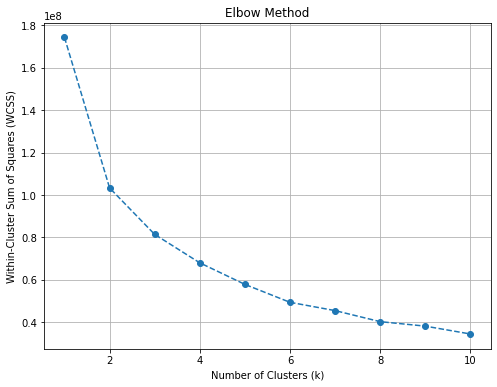

In [61]:
# Calculate the within-cluster sum of squares (WCSS) for different values of k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):  # Trying different values of k from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

In [62]:
#Clustering code using KNN clustering.

kmeans = KMeans(n_clusters=2, random_state=42)

# Fit KMeans to the data
kmeans.fit(X_train)

# Retrieve cluster labels and cluster centers
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

### Write everything to file to give to Krsna. 

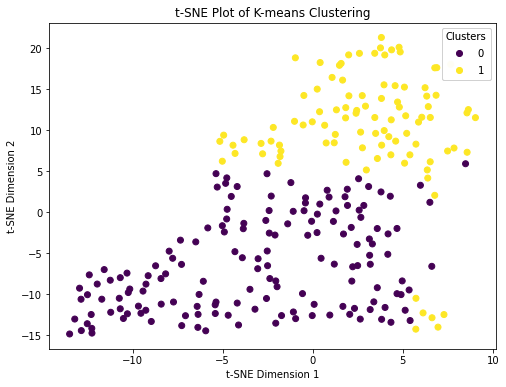

In [64]:
# Save data and labels. 
from sklearn.manifold import TSNE
#Plot TSNE for this data.
tsne = TSNE(n_components=2, random_state=108)
X_tsne = tsne.fit_transform(X_train)

# Plotting the t-SNE plot with clustered data
plt.figure(figsize=(8, 6))

# Plotting points with colors representing clusters
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')

# Adding legend
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Clusters")
plt.gca().add_artist(legend1)

plt.title('t-SNE Plot of K-means Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()